In [1]:
from utils import *

# Genre Interaction Network

How are different game genres interconnected through shared developers or publishers, and what are the implications for genre diversification and cross-genre game development?

In [2]:
df = pd.read_csv(
    'steam.csv', usecols=['name', 'genres', 'developer', 'publisher']
)

In [3]:
row_list = []

for idx, row in (
    df
    .dropna()
    .applymap(lambda x: x.split(';'))
    .explode('name')
    .explode('genres')
    .explode('developer')
    .explode('publisher')
    .rename(columns={'name': 'game'})
).iterrows():
    if row.developer != row.publisher:
        row_list.extend([
            (idx, row.game, row.genres, row.developer),
            (idx, row.game, row.genres, row.publisher)
        ])
    elif row.developer == row.publisher:
        row_list.append((idx, row.game, row.genres, row.developer))

df_genre = (
    pd.DataFrame(
        row_list, columns=['index', 'game', 'genre',
                           'developer_publisher']
    )
    .set_index('index')
)

df_genre.head(10)

,game,genre,developer_publisher
index,,,
0,Counter-Strike,Action,Valve
1,Team Fortress Classic,Action,Valve
2,Day of Defeat,Action,Valve
3,Deathmatch Classic,Action,Valve
4,Half-Life: Opposing Force,Action,Gearbox Software
4,Half-Life: Opposing Force,Action,Valve
5,Ricochet,Action,Valve
6,Half-Life,Action,Valve
7,Counter-Strike: Condition Zero,Action,Valve


In [4]:
genres = set(df_genre['genre'])

shared_dev_pub = {}

for genre1, genre2 in itertools.combinations(genres, 2):
    dev_pub_genre1 = set(
        df_genre[df_genre['genre'] == genre1]['developer_publisher']
    )
    dev_pub_genre2 = set(
        df_genre[df_genre['genre'] == genre2]['developer_publisher']
    )
    shared = len(dev_pub_genre1.intersection(dev_pub_genre2))
    if shared > 0:
        shared_dev_pub[(genre1, genre2)] = shared

In [5]:
df_genre_weight = (
    pd.DataFrame(
        [(genre1, genre2, weight)
         for (genre1, genre2), weight in shared_dev_pub.items()],
        columns=['genre1', 'genre2', 'weight']
    )
)

df_genre_weight

,genre1,genre2,weight
0,Gore,Racing,54
1,Gore,Education,1
2,Gore,Audio Production,1
3,Gore,Sexual Content,67
4,Gore,Free to Play,61
...,...,...,...
326,Violent,Massively Multiplayer,55
327,Violent,Utilities,5
328,Massively Multiplayer,Web Publishing,1
329,Massively Multiplayer,Utilities,1


In [9]:
G = nx.from_pandas_edgelist(df_genre_weight, 'genre1', 'genre2', edge_attr='weight',
                            create_using=nx.Graph())

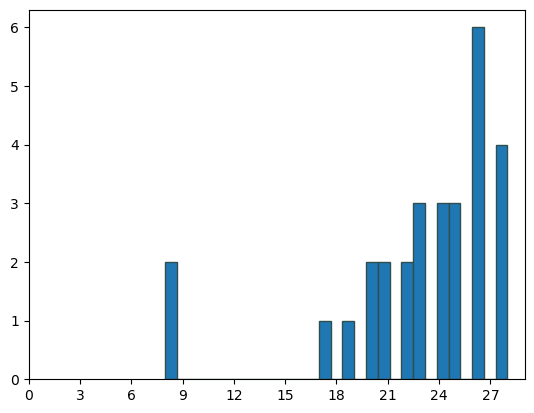

In [10]:
plt.hist(dict(G.degree).values(), bins=len(dict(G.degree).values()), ec='darkslategray')
plt.xticks(range(0, len(dict(G.degree).values()), 3))
plt.show()

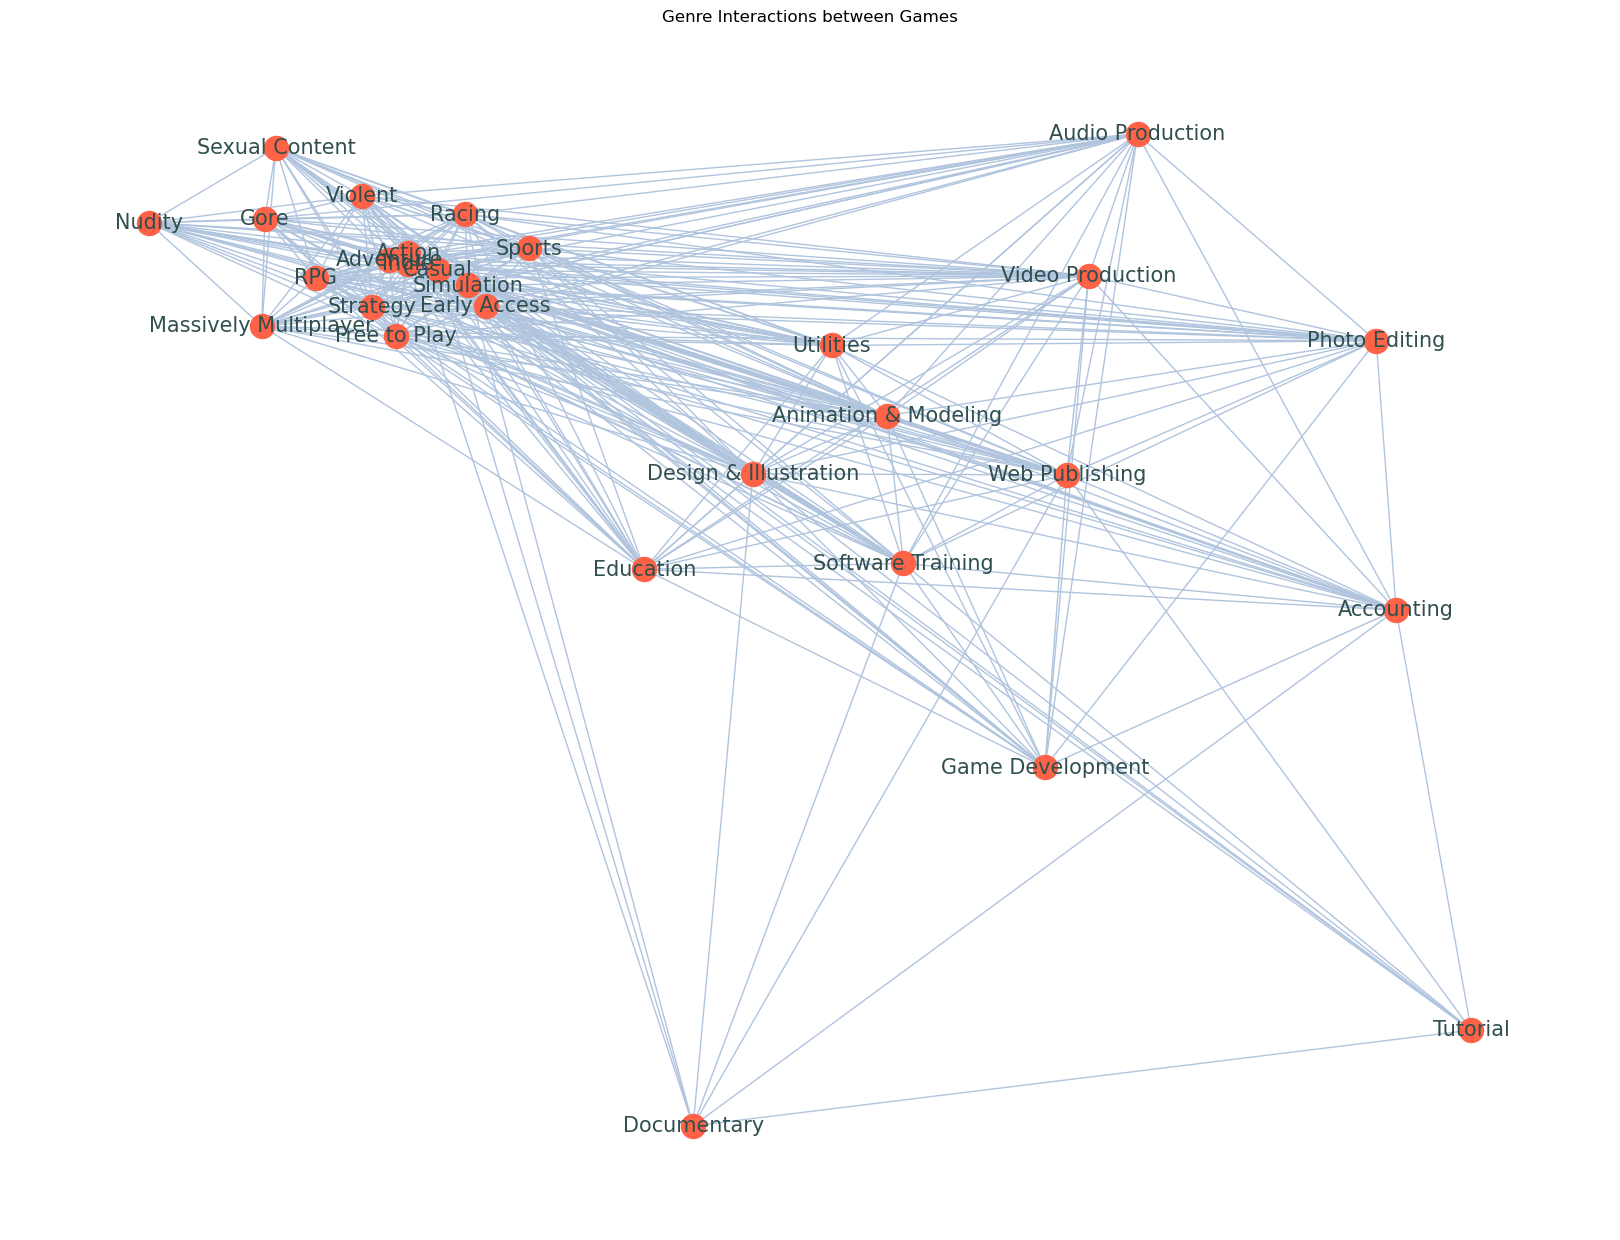

In [11]:
# Position nodes for visualization (you can use other layout algorithms as well)
pos = nx.spring_layout(G, seed=0)

# Draw nodes with different colors based on their roles

# Draw the network with labels and colored nodes
plt.figure(figsize=(16, 12))
nx.draw(G, pos, with_labels=True, node_size=300, node_color='tomato',
        edge_color='lightsteelblue', font_size=15,
        font_color='darkslategray')
edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Genre Interactions between Games")
plt.show()

In [12]:
top_dev_pub = pd.read_csv('developer_publisher.csv')

In [13]:
df_game_genre = (
    df_genre[df_genre.developer_publisher.isin(top_dev_pub.squeeze().tolist())]
    [['game', 'genre']]
)
df_game_genre = df_game_genre.applymap(unidecode)
df_game_genre

,game,genre
index,,
4,Half-Life: Opposing Force,Action
8,Half-Life: Blue Shift,Action
67,Call of Duty(r) 2,Action
67,Call of Duty(r) 2,Action
67,Call of Duty(r) 2,Action
...,...,...
26663,Amaranthine Voyage: The Orb of Purity Collecto...,Casual
27016,Awakening: The Dreamless Castle,Adventure
27016,Awakening: The Dreamless Castle,Adventure


In [34]:
df[(df.genres.str.contains('Ut')) &
   ((df.developer.isin((top_dev_pub.squeeze().tolist()))) |
    (df.publisher.isin((top_dev_pub.squeeze().tolist()))))]

,name,developer,publisher,genres
9106,Disney Movies VR,Walt Disney Studios,Disney Interactive,Utilities


In [37]:
df_game_genre = df_game_genre[df_game_genre.genre != 'Utilities']

In [38]:
G = nx.Graph()
G.add_nodes_from(set(df_game_genre['game']), label='Game')
G.add_nodes_from(set(df_game_genre['genre']), label='Genre')
G.add_edges_from([(game, genre) for game, genre in df_game_genre.to_numpy()])
G
# Separate nodes by bipartite sets for visualization
games = {node for node, attr in G.nodes(data=True) if attr['label'] == 'Game'}
genres = {node for node, attr in G.nodes(data=True) if attr['label'] == 'Genre'}

In [39]:
G_games = nx.bipartite.projected_graph(G, games)

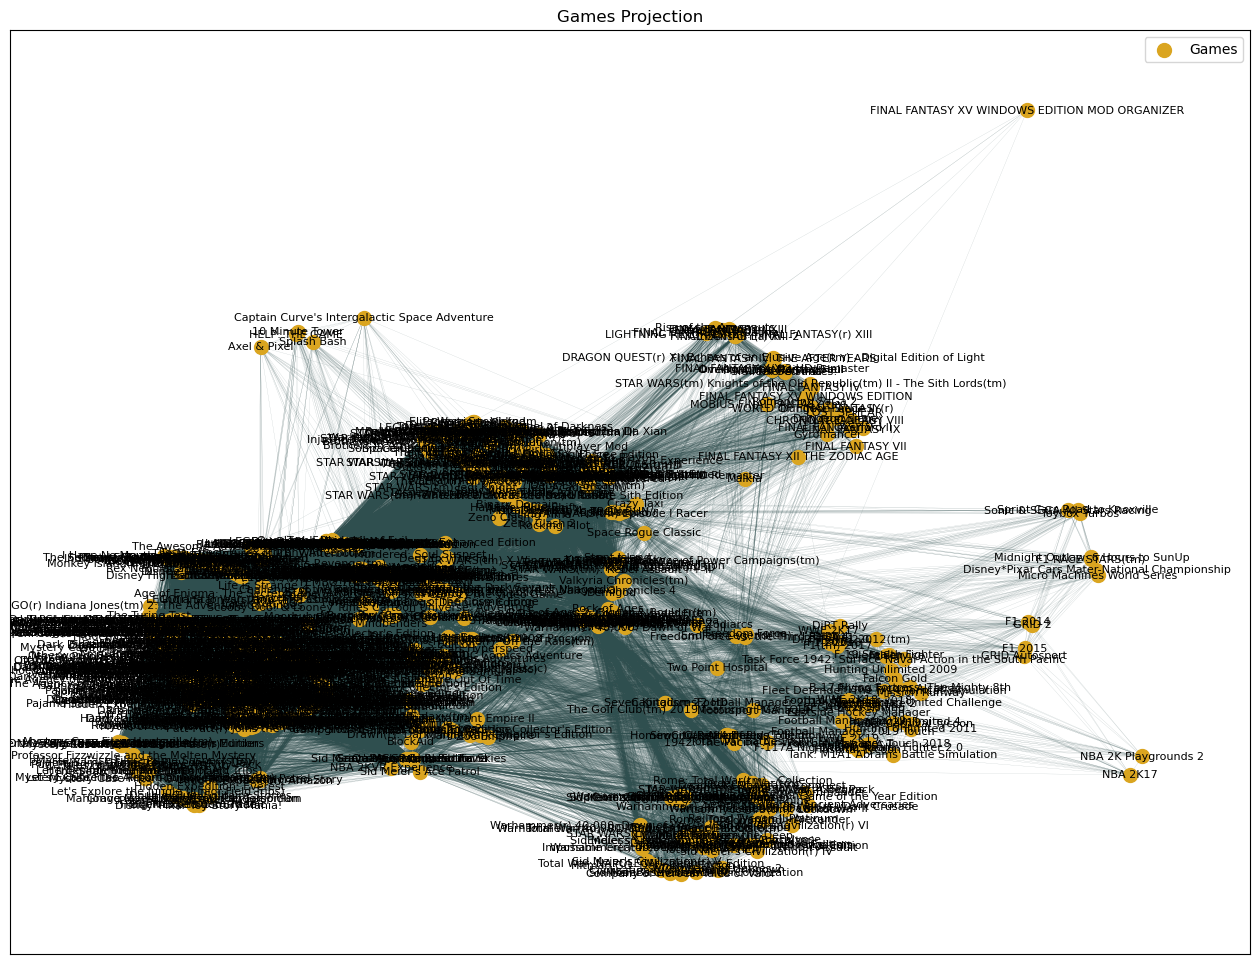

In [60]:
plt.figure(figsize=(16, 12))
pos_games = nx.spring_layout(G_games, seed=0)

# Draw edges first
nx.draw_networkx_edges(G_games, pos_games, alpha=0.5, width=0.1, edge_color='darkslategray')

# Draw nodes on top of edges
nx.draw_networkx_nodes(G_games, pos_games, node_size=100, node_color='goldenrod', label='Games')

# Draw node labels
nx.draw_networkx_labels(G_games, pos_games, font_size=8)

plt.title('Games Projection')
plt.legend()
plt.show()

In [58]:
pd.Series(nx.degree_centrality(G_games)).sort_values(ascending=False)

Thrillville(r): Off the Rails(tm)                 0.893316
Scribblenauts Unmasked: A DC Comics Adventure     0.877892
Rollers of the Realm                              0.845758
Disney's Treasure Planet: Battle of Procyon       0.818766
7th Legion                                        0.818766
                                                    ...   
NBA 2K Playgrounds 2                              0.041131
Sonic & SEGA All-Stars Racing                     0.041131
Sprint Cars Road to Knoxville                     0.041131
Micro Machines World Series                       0.041131
FINAL FANTASY XV WINDOWS EDITION MOD ORGANIZER    0.007712
Length: 779, dtype: float64

In [78]:
c1, c2, c3 = pd.Series(node_colors).reset_index().groupby(0)['index'].apply(list).tolist()

In [80]:
len(c1), len(c2), len(c3)

(294, 336, 149)

/tmp/ipykernel_57433/1021783311.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


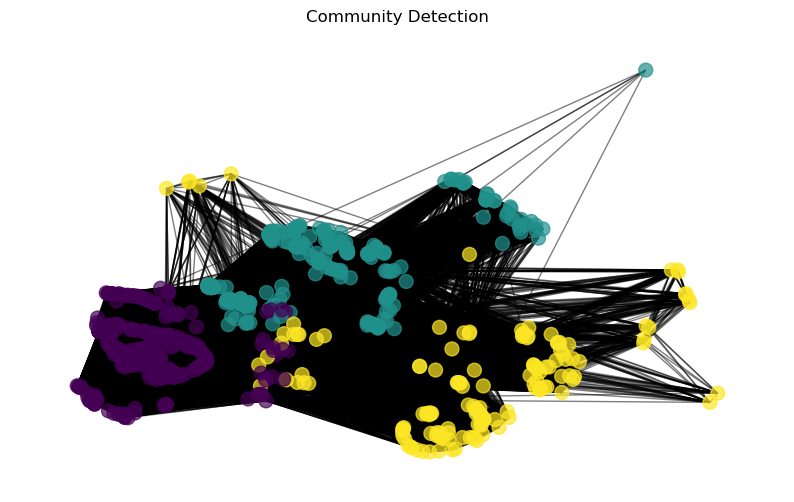

In [71]:
partition = community.best_partition(G_games)

# Create a color map for nodes based on their community
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
node_colors = {node: cmap(partition[node]) for node in G_games.nodes()}

# Draw the subgraph with nodes colored by their community
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G_games, pos_games, node_size=100, node_color=list(node_colors.values()), alpha=0.7)
nx.draw_networkx_edges(G_games, pos_games, alpha=0.5)

# You can add other visual elements like labels, legend, etc. if needed

plt.title("Community Detection")
plt.axis("off")
plt.show()


In [100]:
np.array(G_games.nodes)[top_10_eig].tolist()

['THE QUIET MAN(tm)',
 'MadSpace: To Hell and Beyond',
 "Azada(r) : In Libro Collector's Edition",
 'Sonic Generations Collection',
 'Life is Strange: Before the Storm',
 'Spy Fox In: Cheese Chase',
 'Tomb Raider I',
 "Haunted Train: Spirits of Charon Collector's Edition",
 'FINAL FANTASY V',
 'I am Setsuna']

In [94]:
# Assuming you have already created your NetworkX graph G_games

# Convert the NetworkX graph to an igraph graph
ig_graph = Graph.TupleList(G_games.edges(), directed=False)

# Calculate centrality measures using igraph
ig_deg_centrality = np.array(ig_graph.degree())
ig_bet_centrality = np.array(ig_graph.betweenness())
ig_close_centrality = np.array(ig_graph.closeness())
ig_eig_centrality = np.array(ig_graph.eigenvector_centrality())

# Identify the top 10 central nodes for each centrality measure
top_10_deg = np.argsort(ig_deg_centrality)[-10:][::-1]
top_10_bet = np.argsort(ig_bet_centrality)[-10:][::-1]
top_10_close = np.argsort(ig_close_centrality)[-10:][::-1]
top_10_eig = np.argsort(ig_eig_centrality)[-10:][::-1]

# Print the top 10 central nodes for each centrality measure
print("Top 10 nodes based on Degree Centrality:")
for node in top_10_deg:
    print(f"Node {node} with Degree Centrality: {ig_deg_centrality[node]}")

print("\nTop 10 nodes based on Betweenness Centrality:")
for node in top_10_bet:
    print(f"Node {node} with Betweenness Centrality: {ig_bet_centrality[node]}")

print("\nTop 10 nodes based on Closeness Centrality:")
for node in top_10_close:
    print(f"Node {node} with Closeness Centrality: {ig_close_centrality[node]}")

print("\nTop 10 nodes based on Eigenvector Centrality:")
for node in top_10_eig:
    print(f"Node {node} with Eigenvector Centrality: {ig_eig_centrality[node]}")


Top 10 nodes based on Degree Centrality:
Node 47 with Degree Centrality: 695
Node 251 with Degree Centrality: 683
Node 284 with Degree Centrality: 658
Node 205 with Degree Centrality: 637
Node 363 with Degree Centrality: 637
Node 285 with Degree Centrality: 637
Node 485 with Degree Centrality: 624
Node 366 with Degree Centrality: 622
Node 358 with Degree Centrality: 615
Node 302 with Degree Centrality: 611

Top 10 nodes based on Betweenness Centrality:
Node 47 with Betweenness Centrality: 4180.888641453784
Node 358 with Betweenness Centrality: 4145.092598354937
Node 284 with Betweenness Centrality: 3559.4766414806613
Node 251 with Betweenness Centrality: 2798.358970587831
Node 485 with Betweenness Centrality: 2747.4573429764027
Node 185 with Betweenness Centrality: 2639.595895393934
Node 189 with Betweenness Centrality: 2044.7208765974965
Node 285 with Betweenness Centrality: 1931.0338047676153
Node 205 with Betweenness Centrality: 1931.0338047676153
Node 363 with Betweenness Centralit

In [68]:
from igraph import Graph

# Assuming you have already created your subgraph G_games

# Convert the NetworkX graph to an igraph graph
G_igraph = Graph.TupleList(G_games.edges(), directed=False)

# Perform community detection using the Girvan-Newman algorithm
clusters = G_igraph.community_edge_betweenness(directed=False).as_clustering()

# Create a color map for nodes based on their community
num_communities = len(clusters)
cmap = plt.cm.get_cmap('viridis', num_communities)
node_colors = [cmap(cluster) for cluster in clusters.membership]

# Draw the subgraph with nodes colored by their community
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_games, seed=42)
nx.draw_networkx_nodes(G_games, pos, node_size=300, node_color=node_colors, cmap=cmap, alpha=0.7)
nx.draw_networkx_edges(G_games, pos, alpha=0.5)

plt.title("Community Detection (Girvan-Newman)")
plt.axis("off")
plt.show()


KeyboardInterrupt: 